In [1]:
from __future__ import print_function

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno

import collections
import os
import sys
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from dataset import SIIM_MaskRCNN_Dataset
from util import mask2rle, rle2mask, dice

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
# const

data_path = '../../data/siim-pneumothorax/'


## helpers

In [3]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)
    

In [4]:
# Plot some samples

def plot_sample(img, target_mask=None, result_mask=None):
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    
    ax0.imshow(img)
    if target_mask is not None:
        ax1.imshow(target_mask)
    if result_mask is not None:
        ax2.imshow(result_mask)
    
    ax1.set_title('target')
    ax2.set_title('pred')
    
    plt.show()
    

In [5]:
def train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(train_data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    
    # TODO : save checkpoint
    torch.save(model_ft.state_dict(), "mrcnn_model_{}.pth".format(epoch))
        

In [6]:
dataset_train = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'SIIM_5-FOLD_POS'),
    fold=0,
    phrase='train'
)


100%|██████████| 11582/11582 [00:01<00:00, 9320.45it/s]


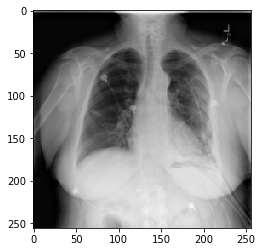

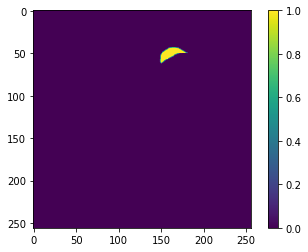

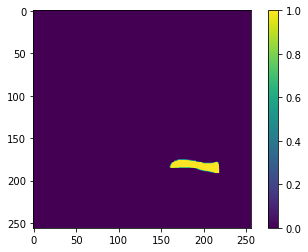

In [7]:
# let's load and watch some sample

for data in dataset_train:
    img, target = data
    
    if target['masks'].shape[0] > 1:
        plt.imshow(img.numpy().transpose((1, 2, 0)))
        plt.show()
        
        for mask in target['masks']:
            plt.imshow(mask)
            plt.colorbar()
            plt.show()
        
        break


In [8]:
# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_nms_thresh=0.,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = True
    

In [9]:
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))


In [10]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)


In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    

Epoch: [0]  [  0/476]  eta: 0:42:13  lr: 0.000003  loss: 4.5561 (4.5561)  loss_classifier: 1.2356 (1.2356)  loss_box_reg: 0.0266 (0.0266)  loss_mask: 3.1500 (3.1500)  loss_objectness: 0.1326 (0.1326)  loss_rpn_box_reg: 0.0113 (0.0113)  time: 5.3219  data: 1.0289  max mem: 6086
Epoch: [0]  [100/476]  eta: 0:03:34  lr: 0.000213  loss: 0.7355 (1.2273)  loss_classifier: 0.1361 (0.2968)  loss_box_reg: 0.0832 (0.0615)  loss_mask: 0.4797 (0.7622)  loss_objectness: 0.0434 (0.0916)  loss_rpn_box_reg: 0.0102 (0.0152)  time: 0.5327  data: 0.0052  max mem: 8089


In [ ]:
torch.save(model_ft.state_dict(), "mrcnn-model.bin")


## eval

In [5]:
# const

model_path = 'mrcnn_5.pth'
image_size = 256

In [6]:
dataset_val = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'SIIM_5-FOLD_POS'),
    fold=0,
    phrase='val'
)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))


100%|██████████| 11582/11582 [00:00<00:00, 12111.19it/s]


In [7]:
# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_nms_thresh=0.1,
    box_detections_per_img=4,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.load_state_dict(torch.load(model_path))
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [8]:
def merge_mask(masks):
    mask = np.amax(masks, axis=0)

    return mask

In [10]:
# find out best score_threshold
score_thres_start = 0.01
score_thres_end = 1
score_thres_step = 0.01

score_thresholds = np.arange(0.01, 1, 0.01)
dice_list = [[] for i in range(len(score_thresholds))]

with torch.no_grad():
    with tqdm(total=len(val_data_loader), file=sys.stdout) as pbar:
        for images, targets in val_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            results = model_ft(images)
            
            # apply score_thresholds
            for sindex, score_threshold in enumerate(score_thresholds):
                
                batch_masks = []
                for i, result in enumerate(results):
                    # merge masks of each sample
                    sample_masks = []
                    
                    for score, mask in zip(result['scores'], result['masks']):
                        if score > score_threshold:
                            sample_masks.append(mask.cpu().numpy().squeeze())
                    
                    if len(sample_masks) > 0:
                        sample_mask = merge_mask(sample_masks)
                    else:
                        sample_mask = np.zeros_like(targets[0]['masks'].cpu().numpy()[0].squeeze())
                    
                    '''
                    plot_sample(
                        images[i].cpu().to(dtype=torch.uint8).numpy().transpose((1, 2, 0)),
                        merge_mask(targets[i]['masks'].cpu().numpy()),
                        sample_mask
                    )
                    '''
                        
                    batch_masks.append(sample_mask)
                    # [print(mask.shape) for mask in masks]
                
                # dice metric of this batch
                metric = dice(
                    torch.from_numpy(np.stack(batch_masks)).squeeze(),
                    torch.stack([torch.from_numpy(merge_mask(target['masks'].cpu().numpy())) for target in targets]).squeeze()
                )
        
                dice_list[sindex].append(metric.item())
            
            pbar.update(1)

dice_list = [np.mean(scores) for scores in dice_list]


100%|██████████| 119/119 [00:47<00:00,  2.47it/s]
[0.3457021104688404, 0.3457021104688404, 0.3457021104688404, 0.3457021104688404, 0.3457021104688404, 0.3502119467789386, 0.3516965489051923, 0.354407142378202, 0.36053238464754167, 0.36423008319209604, 0.3686057788734676, 0.3716384996386135, 0.37293238800112943, 0.37645078970103707, 0.37978038304493206, 0.38048006794532807, 0.38324733253787546, 0.3873535811650653, 0.3879315641966938, 0.3903917156065963, 0.3910774373676346, 0.39536524099149123, 0.396478471557508, 0.3998709475512014, 0.40049993620888025, 0.4019132266995035, 0.4021526491660781, 0.40458158076498185, 0.4057117201419187, 0.40663146889698104, 0.40730893240944177, 0.40939518156610116, 0.41037778642435535, 0.4127553513414469, 0.41315083742579994, 0.4134578367836085, 0.41571909312878835, 0.41648622669530017, 0.41742110543516503, 0.41605579192523195, 0.41760226461191136, 0.41631282906697575, 0.4160545886877705, 0.41500055354808557, 0.41678522154688835, 0.4189172416236721, 0.421769

best score_threshold 0.42244629114240156 @ 0.48000000000000004


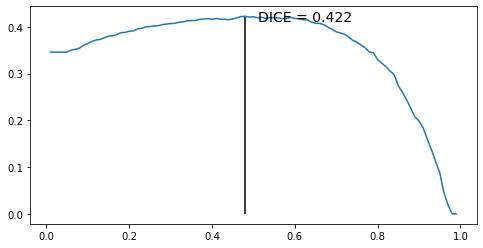

In [13]:
dice_list = np.array(dice_list)

best_dice = dice_list.max()
best_thr = score_thresholds[dice_list.argmax()]

print('best score_threshold {} @ {}'.format(best_dice, best_thr))

plt.figure(figsize=(8,4))

plt.plot(score_thresholds, dice_list)
plt.vlines(x=best_thr, ymin=dice_list.min(), ymax=dice_list.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);

plt.show()

## test

In [5]:
# const

model_path = 'mrcnn_5.pth'
image_size = 256

best_thr = 0.48000000000000004

In [6]:
test_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
test_df = test_df.drop_duplicates('ImageId', keep='last').reset_index(drop=True)

# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_score_thresh=best_thr,
    box_nms_thresh=0.03,
    box_detections_per_img=4,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.load_state_dict(torch.load(model_path))
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [7]:
test_trans = transforms.ToTensor()

all_scores = []
all_masks = []
all_ids = []

with torch.no_grad():
    for index, row in tqdm(test_df.iterrows(), total=len(test_df), file=sys.stdout):
        image_id = row['ImageId']
        img_path = os.path.join(data_path, 'test_png', '{}.png'.format(image_id))

        img = Image.open(img_path).convert('RGB')
        width, height = img.size

        img = img.resize((image_size, image_size), resample=Image.BILINEAR)
        img = test_trans(img)

        result = model_ft([img.to(device)])[0]

        all_scores.append(result['scores'].cpu().numpy())
        all_masks.append(result['masks'].cpu().numpy())
        all_ids.append(image_id)


100%|██████████| 1372/1372 [01:17<00:00, 17.72it/s]


In [19]:
import multiprocessing as mp

sub_list = []
mask_size = 1024

def mask_worker(result):
    image_id, scores, masks = result
    
    if len(masks) > 0:
        filtered_masks = []

        # filter mask with score_threshold
        for score, mask in zip(scores, masks):
            if score > best_thr:
                filtered_masks.append(mask)

        if len(filtered_masks) <= 0:
            rle = ' -1'

            return [image_id, rle]
        else:
            # merge masks
            # mask = np.amax([mask.squeeze().cpu().numpy() for mask in masks], axis=0)

            for mask in filtered_masks:
                # post-processing - resize and convert to hard mask
                res = Image.fromarray((mask.squeeze()).astype(np.uint8))
                res = np.asarray(res.resize((mask_size, mask_size), resample=Image.BILINEAR))

                res = (res[:, :] * 255. > 127).astype(np.uint8)

                # plot_sample(np.array(img).transpose((1, 2, 0)), result_mask=res)

                rle = mask2rle(res.T, mask_size, mask_size)
                # print('rle {}'.format(rle))

                return [image_id, rle]
    else:
        # print(image_id)
        rle = " -1"

        return [image_id, rle]

pool = mp.Pool()

sub_list = pool.map(mask_worker, zip(all_ids, all_scores, all_masks))

pool.close()

'''
with tqdm(total=len(all_ids)) as pbar:
    for image_id, scores, masks in zip(all_ids, all_scores, all_masks):
        if len(masks) > 0:
            filtered_masks = []

            # filter mask with score_threshold
            for score, mask in zip(scores, masks):
                if score > best_thr:
                    filtered_masks.append(mask)

            if len(filtered_masks) <= 0:
                rle = ' -1'

                sub_list.append([image_id, rle])
            else:
                # merge masks
                # mask = np.amax([mask.squeeze().cpu().numpy() for mask in masks], axis=0)

                for mask in filtered_masks:
                    # post-processing - resize and convert to hard mask
                    res = transforms.ToPILImage()(torch.from_numpy(mask))
                    res = np.asarray(res.resize((mask_size, mask_size), resample=Image.BILINEAR))

                    res = (res[:, :] * 255. > 127).astype(np.uint8)

                    # plot_sample(np.array(img).transpose((1, 2, 0)), result_mask=res)

                    rle = mask2rle(res.T, mask_size, mask_size)
                    # print('rle {}'.format(rle))

                    sub_list.append([image_id, rle])
        else:
            # print(image_id)
            rle = " -1"

            sub_list.append([image_id, rle])
            
        pbar.update(1)
'''

(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 25

'\nwith tqdm(total=len(all_ids)) as pbar:\n    for image_id, scores, masks in zip(all_ids, all_scores, all_masks):\n        if len(masks) > 0:\n            filtered_masks = []\n\n            # filter mask with score_threshold\n            for score, mask in zip(scores, masks):\n                if score > best_thr:\n                    filtered_masks.append(mask)\n\n            if len(filtered_masks) <= 0:\n                rle = \' -1\'\n\n                sub_list.append([image_id, rle])\n            else:\n                # merge masks\n                # mask = np.amax([mask.squeeze().cpu().numpy() for mask in masks], axis=0)\n\n                for mask in filtered_masks:\n                    # post-processing - resize and convert to hard mask\n                    res = transforms.ToPILImage()(torch.from_numpy(mask))\n                    res = np.asarray(res.resize((mask_size, mask_size), resample=Image.BILINEAR))\n\n                    res = (res[:, :] * 255. > 127).astype(np.uint8)\n

In [20]:
sub_df = pd.DataFrame(sub_list, columns=['ImageId', 'EncodedPixels'])
sub_df.head(5)
sub_df.to_csv('sub.csv', index=False)


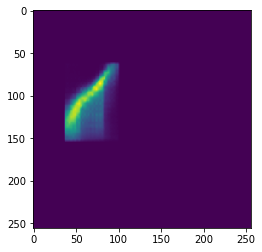

In [13]:
plt.imshow(result['masks'][0].permute(1, 2, 0).squeeze().cpu().numpy())
plt.show()